## Car Accidents & COVID: Cleaning & EDA of Data
Notebook 1 of 3 for this project where we gather, clean, and do exploratory analysis of the data.

First, import libraries and modules needed >

In [48]:
import pandas as pd
import datetime
import re
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

### Gather the base data
Pull in the core dataset that will be used for this project >

In [49]:
car_accidents_original = pd.read_csv('csv/US_Accidents_June20.csv')  

In [50]:
# verify demensions of dataset

car_accidents_original.shape

(3513617, 49)

In [51]:
# look at sections of data

car_accidents_original.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

### Get to know the data
Let's do preliminary EDA to better understand the dataset and what we have to work with.

In [52]:
# let's see how many cities are represented 

len(car_accidents_original.City.unique())

11896

In [53]:
# let's see how many cities are represented

len(car_accidents_original.State.unique())

49

Seems one state is not represented -- let's find out which one >

In [54]:
sorted(car_accidents_original.State.unique())

['AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC',
 'DE',
 'FL',
 'GA',
 'IA',
 'ID',
 'IL',
 'IN',
 'KS',
 'KY',
 'LA',
 'MA',
 'MD',
 'ME',
 'MI',
 'MN',
 'MO',
 'MS',
 'MT',
 'NC',
 'ND',
 'NE',
 'NH',
 'NJ',
 'NM',
 'NV',
 'NY',
 'OH',
 'OK',
 'OR',
 'PA',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VA',
 'VT',
 'WA',
 'WI',
 'WV',
 'WY']

We see here that actually both Alaska and Hawaii are not represented state and DC is treated as a state, which explains the 49 total 'states' in teh set.  Will make note of that in the analysis and reporting.  This analysis will not include Alaska and Hawaii.

In [55]:
car_accidents_original["State"].value_counts().OH.sum()

66139

Now let's look at how many car accidents/incidents are in each state >

In [56]:
car_accidents_original.groupby(['State']).size().reset_index(name='counts')

,State,counts
0,AL,44625
1,AR,2012
2,AZ,78584
3,CA,816825
4,CO,49731
5,CT,25901
6,DC,4820
7,DE,5739
8,FL,258002
9,GA,93614


A few states -- SD and ND -- have extremely low counts.  I conducted outside research to examine whether that's missing information or because those states just have lower incidents in general and my research found that this dataset is not completely comprehensive of *all* traffic incidents.  So any anylsis, modeling, and conclusions will need to keep that mind.

Let's move to looking at the exact date range of this data >

In [57]:
# time of first car accident in dataset

car_accidents_original.Start_Time.head(1)

0    2016-02-08 05:46:00
Name: Start_Time, dtype: object

In [58]:
# first date of car accident in data set

car_accidents_original.sort_values(by=['Start_Time']).Start_Time.head(1)

2478818    2016-02-08 00:37:08
Name: Start_Time, dtype: object

In [59]:
# last date of car accident in data set

car_accidents_original.sort_values(by=['Start_Time']).Start_Time.tail(1)

560472    2020-06-30 23:18:09
Name: Start_Time, dtype: object

Here we can see car accidents in this dataset range in dates from 2/8/2016 to 6/30/2020.  This is inline with what was expected to see.

Now let's see how many missing values there are and where they are concentrated >

### Basic cleaning of the data
Start to reduce and clean the dataset to prepare for more EDA and eventual modeling

In [12]:
# see null values for each column

car_accidents_original.isnull().sum(axis = 0)

ID                             0
Source                         0
TMC                      1034799
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2478818
End_Lng                  2478818
Distance(mi)                   0
Description                    1
Number                   2262864
Street                         0
Side                           0
City                         112
County                         0
State                          0
Zipcode                     1069
Country                        0
Timezone                    3880
Airport_Code                6758
Weather_Timestamp          43323
Temperature(F)             65732
Wind_Chill(F)            1868249
Humidity(%)                69687
Pressure(in)               55882
Visibility(mi)             75856
Wind_Direction             58874
Wind_Speed(mph)           454609
Precipitat

Unfortunately seems there quite a few missing related to weather.  Precipitation and  Wind Speed are particular ones that were of interest but have such high values of missing null values, may have to be removed.  Or could test models with much lower sample.  Other features with high null values missing are not that critical and were going to be removed anyways before modeling.

Let's see if by chance the null values for Precipitation just mean there was 0 zero precipitation by seeing if there are any values equal to zero. If not, that is a strong sign that null = 0 >

In [7]:
len(car_accidents_original[car_accidents_original['Precipitation(in)'] == 0])

1238383

Nope, plenty of zero values for Precipitation, so we cannot say null values = 0 with a strong level of confidence.

Let's do the same thing for Wind Speed >

In [28]:
len(car_accidents_original[car_accidents_original['Wind_Speed(mph)'] == 0])

217426

Again, there are 0 values for wind speed so we cannot assume that null values = 0 with confidence.

Now let's look at oveall weather conditions, starting with how many values there are > 

In [13]:
len(car_accidents_original['Weather_Condition'].value_counts()[
    car_accidents_original['Weather_Condition'].value_counts() > 1000])

38

Even when only looking at values with a count higher than 1000, we see that we're still left with 38 different values.  Let's look at the unique values to see if opportunities to bin them >

In [30]:
car_accidents_original['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Rain', 'Light Snow',
       'Haze', 'Scattered Clouds', 'Partly Cloudy', 'Clear', 'Snow',
       'Light Freezing Drizzle', 'Light Drizzle', 'Fog', 'Shallow Fog',
       'Heavy Rain', 'Light Freezing Rain', 'Cloudy', 'Drizzle', nan,
       'Light Rain Showers', 'Mist', 'Smoke', 'Patches of Fog',
       'Light Freezing Fog', 'Light Haze', 'Light Thunderstorms and Rain',
       'Thunderstorms and Rain', 'Fair', 'Volcanic Ash', 'Blowing Sand',
       'Blowing Dust / Windy', 'Widespread Dust', 'Fair / Windy',
       'Rain Showers', 'Mostly Cloudy / Windy', 'Light Rain / Windy',
       'Hail', 'Heavy Drizzle', 'Showers in the Vicinity', 'Thunderstorm',
       'Light Rain Shower', 'Light Rain with Thunder',
       'Partly Cloudy / Windy', 'Thunder in the Vicinity', 'T-Storm',
       'Heavy Thunderstorms and Rain', 'Thunder', 'Heavy T-Storm',
       'Funnel Cloud', 'Heavy T-Storm / Windy', 'Blowing Snow',
       'Light Thunderstorms and Snow',

Fairly diverse set of descriptions for weather condition, but this may be the better approach to having a feature that will account for preciptation since otherwise we'll have to remove a number of null values.

Let's look to bucket these values into basic categories of:
1. Rain/Thunderstorms
2. Snow/Hail
3. Cloudy
4. Foggy/Hazy
5. Dusty
6. Clear/Fair
7. Smoke
8. Wintry Mix

Any minimal remaining values will be removed from the dataset, as they won't have enough samples to have proper impact/representation in the models or analysis.  Note that 'windy' has been left out because it is paired with other weather conditions we need to identify and wind will be covered in our wind velocity data column, so it's not needed here and will allow our categories to be cleaner without it.


In [60]:
# creating 1. 'Rain/Thunderstorm' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Rain.*|.*Thunderstorm.*|.*T-Storm.*|.*Thunder.*|.*Drizzle.*|.*Showers.*|.*Mist.*', 
    value = 'Rain/Thunderstorms', regex = True, inplace=True)



In [61]:
# creating 2. 'Snow/Hail' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Snow.*|.*Hail.*|.*Sleet.*|.*Ice.*', 
    value = 'Snow/Hail', regex = True, inplace=True)

In [62]:
# creating 3. 'Cloudy' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Cloud.*', 
    value = 'Cloudy', regex = True, inplace=True)

In [63]:
# creating 4. 'Foggy/Hazy' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Fog.*|.*Haze.*', value = 'Foggy/Hazy', regex = True, inplace=True)

In [64]:
# creating 5. 'Dusty' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Dust.*', 
    value = 'Dusty', regex = True, inplace=True)

In [65]:
# creating 6. 'Clear/Fair' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Clear.*|.*Fair.*', value = 'Clear/Fair', regex = True, inplace=True)

In [66]:
# creating 7. 'Smoke' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Smoke.*', 
    value = 'Smoke', regex = True, inplace=True)

In [67]:
# creating 8. 'Wintery Mix' bucket

car_accidents_original['Weather_Condition'].replace(
    to_replace ='.*Wintry.*', 
    value = 'Wintry Mix', regex = True, inplace=True)

In [68]:
car_accidents_original.Weather_Condition.value_counts()

Clear/Fair            1363877
Cloudy                1262085
Overcast               382485
Rain/Thunderstorms     287970
Foggy/Hazy              74932
Snow/Hail               59852
Smoke                    3683
Wintry Mix               1721
N/A Precipitation         420
Dusty                     372
Squalls                    26
Volcanic Ash               22
Sand                       19
Squalls / Windy            11
Tornado                     3
Blowing Sand                1
Name: Weather_Condition, dtype: int64

In [23]:
# now drop remaining weather conditions that didn't fit in main buckets

drop_weather = ['N/A Precipitation','Squalls','Volcanic Ash',
                'Sand','Squalls / Windy','Tornado','Blowing Sand']

for weather_condition in drop_weather:
    car_accidents_original.drop(car_accidents_original.loc[
        car_accidents_original['Weather_Condition']== weather_condition]
                                .index, inplace=True)

In [18]:
# verify we have all of the buckets we want for weather conditions

car_accidents_original.Weather_Condition.value_counts()

Clear/Fair            1363877
Cloudy                1262085
Overcast               382485
Rain/Thunderstorms     287970
Foggy/Hazy              74932
Snow/Hail               59852
Smoke                    3683
Wintry Mix               1721
Dusty                     372
Name: Weather_Condition, dtype: int64

Now start creating a new dataframe, keeping the columns we want to consider and then removing null values to see what we're left with >

In [24]:
car_accidents_master = car_accidents_original.drop([
    'TMC', 'Start_Lat','Start_Lng', 'End_Time',
    'End_Lat','End_Lng','Distance(mi)',
    'Description','Number','Airport_Code',
    'Weather_Timestamp','Wind_Chill(F)',
    'Precipitation(in)','Amenity','Civil_Twilight',
    'Nautical_Twilight','Astronomical_Twilight']
    ,axis=1)

In [25]:
# Rename Start_Time to just be Date, representing the date of the accident

car_accidents_master.rename(columns={'Start_Time':'Date'}, inplace=True)

In [26]:
# look at number null values in refined dataset 

car_accidents_master.isnull().sum()

ID                        0
Source                    0
Severity                  0
Date                      0
Street                    0
Side                      0
City                    112
County                    0
State                     0
Zipcode                1069
Country                   0
Timezone               3880
Temperature(F)        65690
Humidity(%)           69619
Pressure(in)          55858
Visibility(mi)        75845
Wind_Direction        58837
Wind_Speed(mph)      454542
Weather_Condition     76138
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Turning_Loop              0
Sunrise_Sunset          115
dtype: int64

In [45]:
# look at types of data in the dataset

car_accidents_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513115 entries, 0 to 3513616
Data columns (total 32 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ID                 object 
 1   Source             object 
 2   Severity           int64  
 3   Date               object 
 4   Street             object 
 5   Side               object 
 6   City               object 
 7   County             object 
 8   State              object 
 9   Zipcode            object 
 10  Country            object 
 11  Timezone           object 
 12  Temperature(F)     float64
 13  Humidity(%)        float64
 14  Pressure(in)       float64
 15  Visibility(mi)     float64
 16  Wind_Direction     object 
 17  Wind_Speed(mph)    float64
 18  Weather_Condition  object 
 19  Bump               bool   
 20  Crossing           bool   
 21  Give_Way           bool   
 22  Junction           bool   
 23  No_Exit            bool   
 24  Railway            bool   
 25  Roundabout        

For future analysis and potentially modeling, we want to separate year, month, and day into new independent columns >

In [27]:
# Let's make a new column that disinguishes year only 

car_accidents_master['Year'] = pd.DatetimeIndex(car_accidents_master['Date']).year
car_accidents_master.head()

,ID,Source,Severity,Date,Street,Side,City,County,State,Zipcode,...,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year
0,A-1,MapQuest,3,2016-02-08 05:46:00,I-70 E,R,Dayton,Montgomery,OH,45424,...,False,False,False,False,False,False,False,False,Night,2016
1,A-2,MapQuest,2,2016-02-08 06:07:59,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,...,False,False,False,False,False,False,False,False,Night,2016
2,A-3,MapQuest,2,2016-02-08 06:49:27,State Route 32,R,Williamsburg,Clermont,OH,45176,...,False,False,False,False,False,False,True,False,Night,2016
3,A-4,MapQuest,3,2016-02-08 07:23:34,I-75 S,R,Dayton,Montgomery,OH,45417,...,False,False,False,False,False,False,False,False,Night,2016
4,A-5,MapQuest,2,2016-02-08 07:39:07,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,...,False,False,False,False,False,False,True,False,Day,2016


In [29]:
# Let's make a new column that disinguishes month only 

car_accidents_master['Month'] = pd.DatetimeIndex(car_accidents_master['Date']).month
car_accidents_master.head()

,ID,Source,Severity,Date,Street,Side,City,County,State,Zipcode,...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month
0,A-1,MapQuest,3,2016-02-08 05:46:00,I-70 E,R,Dayton,Montgomery,OH,45424,...,False,False,False,False,False,False,False,Night,2016,2
1,A-2,MapQuest,2,2016-02-08 06:07:59,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,...,False,False,False,False,False,False,False,Night,2016,2
2,A-3,MapQuest,2,2016-02-08 06:49:27,State Route 32,R,Williamsburg,Clermont,OH,45176,...,False,False,False,False,False,True,False,Night,2016,2
3,A-4,MapQuest,3,2016-02-08 07:23:34,I-75 S,R,Dayton,Montgomery,OH,45417,...,False,False,False,False,False,False,False,Night,2016,2
4,A-5,MapQuest,2,2016-02-08 07:39:07,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,...,False,False,False,False,False,True,False,Day,2016,2


In [30]:
# A new column that disinguishes day only 

car_accidents_master['Day'] = pd.DatetimeIndex(car_accidents_master['Date']).day
car_accidents_master.head()

,ID,Source,Severity,Date,Street,Side,City,County,State,Zipcode,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day
0,A-1,MapQuest,3,2016-02-08 05:46:00,I-70 E,R,Dayton,Montgomery,OH,45424,...,False,False,False,False,False,False,Night,2016,2,8
1,A-2,MapQuest,2,2016-02-08 06:07:59,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,...,False,False,False,False,False,False,Night,2016,2,8
2,A-3,MapQuest,2,2016-02-08 06:49:27,State Route 32,R,Williamsburg,Clermont,OH,45176,...,False,False,False,False,True,False,Night,2016,2,8
3,A-4,MapQuest,3,2016-02-08 07:23:34,I-75 S,R,Dayton,Montgomery,OH,45417,...,False,False,False,False,False,False,Night,2016,2,8
4,A-5,MapQuest,2,2016-02-08 07:39:07,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,...,False,False,False,False,True,False,Day,2016,2,8


In [25]:
# A new column that disinguishes the day of the week 

car_accidents_master['Day_Of_Week'] = pd.DatetimeIndex(car_accidents_master['Date']).dayofweek
car_accidents_master.head()

,ID,Source,Severity,Date,Street,Side,City,County,State,Zipcode,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Year,Month,Day,Day_Of_Week
0,A-1,MapQuest,3,2016-02-08 05:46:00,I-70 E,R,Dayton,Montgomery,OH,45424,...,False,False,False,False,False,Night,2016,2,8,0
1,A-2,MapQuest,2,2016-02-08 06:07:59,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,...,False,False,False,False,False,Night,2016,2,8,0
2,A-3,MapQuest,2,2016-02-08 06:49:27,State Route 32,R,Williamsburg,Clermont,OH,45176,...,False,False,False,True,False,Night,2016,2,8,0
3,A-4,MapQuest,3,2016-02-08 07:23:34,I-75 S,R,Dayton,Montgomery,OH,45417,...,False,False,False,False,False,Night,2016,2,8,0
4,A-5,MapQuest,2,2016-02-08 07:39:07,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,...,False,False,False,True,False,Day,2016,2,8,0


Now we want to add a column that will indicate whether the state was in a COVID shutdown.  Will be 1 if yes and 0 if no >

In [31]:
# Masks for each state's specific date range that it was (if ever) under 'stay-home' orders 

# Alabama
AL_mask = ((car_accidents_master['Date'] > '2020-04-04') & 
    (car_accidents_master['Date'] <= '2020-04-30') & 
    (car_accidents_master['State'] == 'AL'))

# Arkansas - n/a, never had stay home order

# Arizona
AZ_mask = ((car_accidents_master['Date'] > '2020-03-31') & 
    (car_accidents_master['Date'] <= '2020-05-15') & 
    (car_accidents_master['State'] == 'AZ'))

# California
CA_mask = ((car_accidents_master['Date'] > '2020-03-19') & 
    (car_accidents_master['State'] == 'CA'))

# Colorado
CO_mask = ((car_accidents_master['Date'] > '2020-03-26') & 
    (car_accidents_master['Date'] <= '2020-04-26') & 
    (car_accidents_master['State'] == 'CO'))

# Connecticut
CT_mask = ((car_accidents_master['Date'] > '2020-03-23') & 
    (car_accidents_master['Date'] <= '2020-05-20') & 
    (car_accidents_master['State'] == 'CT'))

# District of Columbia
DC_mask = ((car_accidents_master['Date'] > '2020-04-01') & 
    (car_accidents_master['Date'] <= '2020-06-08') & 
    (car_accidents_master['State'] == 'DC'))

# Deleware
DE_mask = ((car_accidents_master['Date'] > '2020-03-24') & 
    (car_accidents_master['Date'] <= '2020-05-31') & 
    (car_accidents_master['State'] == 'DE'))

# Florida
FL_mask = ((car_accidents_master['Date'] > '2020-04-03') & 
    (car_accidents_master['Date'] <= '2020-04-30') & 
    (car_accidents_master['State'] == 'FL'))

# Georgia
GA_mask = ((car_accidents_master['Date'] > '2020-04-03') & 
    (car_accidents_master['Date'] <= '2020-04-30') & 
    (car_accidents_master['State'] == 'GA'))

# Iowa - n/a, never had stay home order

# Idaho
ID_mask = ((car_accidents_master['Date'] > '2020-03-25') & 
    (car_accidents_master['Date'] <= '2020-04-30') & 
    (car_accidents_master['State'] == 'ID'))

# Illinois
IL_mask = ((car_accidents_master['Date'] > '2020-03-25') & 
    (car_accidents_master['Date'] <= '2020-05-31') & 
    (car_accidents_master['State'] == 'IL'))

# Indiana
IN_mask = ((car_accidents_master['Date'] > '2020-03-21') & 
    (car_accidents_master['Date'] <= '2020-05-01') & 
    (car_accidents_master['State'] == 'IN'))

# Kansas
KS_mask = ((car_accidents_master['Date'] > '2020-03-30') & 
    (car_accidents_master['Date'] <= '2020-05-03') & 
    (car_accidents_master['State'] == 'KS'))

# Kentucky
KY_mask = ((car_accidents_master['Date'] > '2020-03-26') &  
    (car_accidents_master['State'] == 'KY'))

# Louisiana
LA_mask = ((car_accidents_master['Date'] > '2020-03-22') & 
    (car_accidents_master['Date'] <= '2020-05-15') & 
    (car_accidents_master['State'] == 'LA'))

# Massachusetts
MA_mask = ((car_accidents_master['Date'] > '2020-03-24') & 
    (car_accidents_master['Date'] <= '2020-05-18') & 
    (car_accidents_master['State'] == 'MA'))

# Maryland
MD_mask = ((car_accidents_master['Date'] > '2020-03-30') & 
    (car_accidents_master['Date'] <= '2020-05-15') & 
    (car_accidents_master['State'] == 'MD'))

# Maine
ME_mask = ((car_accidents_master['Date'] > '2020-04-02') & 
    (car_accidents_master['Date'] <= '2020-05-31') & 
    (car_accidents_master['State'] == 'ME'))

# Michigan
MI_mask = ((car_accidents_master['Date'] > '2020-03-24') & 
    (car_accidents_master['Date'] <= '2020-05-28') & 
    (car_accidents_master['State'] == 'MI'))

# Minnesota
MN_mask = ((car_accidents_master['Date'] > '2020-03-27') & 
    (car_accidents_master['Date'] <= '2020-05-17') & 
    (car_accidents_master['State'] == 'MN'))

# Missouri
MO_mask = ((car_accidents_master['Date'] > '2020-04-06') & 
    (car_accidents_master['Date'] <= '2020-05-03') & 
    (car_accidents_master['State'] == 'MO'))

# Montana
MT_mask = ((car_accidents_master['Date'] > '2020-03-28') & 
    (car_accidents_master['Date'] <= '2020-04-26') & 
    (car_accidents_master['State'] == 'MT'))

# North Carolina
NC_mask = ((car_accidents_master['Date'] > '2020-03-30') & 
    (car_accidents_master['Date'] <= '2020-05-22') & 
    (car_accidents_master['State'] == 'NC'))

# North Dakota - n/a, never had stay home order

# Nebraska - n/a, never had stay home order

# New Hampshire
NH_mask = ((car_accidents_master['Date'] > '2020-03-27') & 
    (car_accidents_master['Date'] <= '2020-06-15') & 
    (car_accidents_master['State'] == 'NH'))

# New Jersey
NJ_mask = ((car_accidents_master['Date'] > '2020-03-21') & 
    (car_accidents_master['State'] == 'NJ'))

# New Mexico
NM_mask = ((car_accidents_master['Date'] > '2020-03-24') & 
    (car_accidents_master['Date'] <= '2020-05-31') & 
    (car_accidents_master['State'] == 'NM'))

# Nevada
NV_mask = ((car_accidents_master['Date'] > '2020-04-02') & 
    (car_accidents_master['Date'] <= '2020-05-09') & 
    (car_accidents_master['State'] == 'NV'))

# New York
NY_mask = ((car_accidents_master['Date'] > '2020-03-22') & 
    (car_accidents_master['Date'] <= '2020-06-13') & 
    (car_accidents_master['State'] == 'NY'))

# Ohio
OH_mask = ((car_accidents_master['Date'] > '2020-03-22') & 
    (car_accidents_master['Date'] <= '2020-06-13') & 
    (car_accidents_master['State'] == 'OH'))

# Oklahoma
OK_mask = ((car_accidents_master['Date'] > '2020-03-24') & 
    (car_accidents_master['Date'] <= '2020-05-06') & 
    (car_accidents_master['State'] == 'OK'))

# Oregon
OR_mask = ((car_accidents_master['Date'] > '2020-03-23') & 
    (car_accidents_master['State'] == 'OR'))

# Pennsylvania
PA_mask = ((car_accidents_master['Date'] > '2020-03-23') & 
    (car_accidents_master['Date'] <= '2020-06-04') & 
    (car_accidents_master['State'] == 'PA'))

# Rhode Island
RI_mask = ((car_accidents_master['Date'] > '2020-03-28') & 
    (car_accidents_master['Date'] <= '2020-05-08') & 
    (car_accidents_master['State'] == 'RI'))

# South Carolina
SC_mask = ((car_accidents_master['Date'] > '2020-04-06') & 
    (car_accidents_master['Date'] <= '2020-05-04') & 
    (car_accidents_master['State'] == 'SC'))

# South Dakota - n/a, never had stay home order

# Tennessee
TN_mask = ((car_accidents_master['Date'] > '2020-03-31') & 
    (car_accidents_master['Date'] <= '2020-04-30') & 
    (car_accidents_master['State'] == 'TN'))

# Texas
TX_mask = ((car_accidents_master['Date'] > '2020-03-31') & 
    (car_accidents_master['Date'] <= '2020-04-30') & 
    (car_accidents_master['State'] == 'TX'))

# Utah
UT_mask = ((car_accidents_master['Date'] > '2020-03-27') & 
    (car_accidents_master['Date'] <= '2020-05-01') & 
    (car_accidents_master['State'] == 'UT'))

# Virginia
VA_mask = ((car_accidents_master['Date'] > '2020-03-30') & 
    (car_accidents_master['Date'] <= '2020-06-10') & 
    (car_accidents_master['State'] == 'VA'))

# Vermont
VT_mask = ((car_accidents_master['Date'] > '2020-03-24') & 
    (car_accidents_master['Date'] <= '2020-05-15') & 
    (car_accidents_master['State'] == 'VT'))

# Washington
WA_mask = ((car_accidents_master['Date'] > '2020-03-23') & 
    (car_accidents_master['Date'] <= '2020-05-31') & 
    (car_accidents_master['State'] == 'WA'))

# Wisconsin
WI_mask = ((car_accidents_master['Date'] > '2020-03-25') & 
    (car_accidents_master['Date'] <= '2020-05-26') & 
    (car_accidents_master['State'] == 'WI'))

# West Virginia
WV_mask = ((car_accidents_master['Date'] > '2020-03-24') & 
    (car_accidents_master['Date'] <= '2020-05-04') & 
    (car_accidents_master['State'] == 'WV'))

# Wyoming - n/a, never had stay home order




In [32]:
# create new column for shutdown period, defaulting to 0

car_accidents_master['Shut_Down'] = 0

In [33]:
# Now apply masks for each state and assign 1 value for each

car_accidents_master['Shut_Down'][AL_mask] = 1
car_accidents_master['Shut_Down'][AZ_mask] = 1
car_accidents_master['Shut_Down'][CA_mask] = 1
car_accidents_master['Shut_Down'][CO_mask] = 1
car_accidents_master['Shut_Down'][CT_mask] = 1
car_accidents_master['Shut_Down'][DC_mask] = 1
car_accidents_master['Shut_Down'][DE_mask] = 1
car_accidents_master['Shut_Down'][FL_mask] = 1
car_accidents_master['Shut_Down'][GA_mask] = 1
car_accidents_master['Shut_Down'][ID_mask] = 1
car_accidents_master['Shut_Down'][IL_mask] = 1
car_accidents_master['Shut_Down'][IN_mask] = 1
car_accidents_master['Shut_Down'][KS_mask] = 1
car_accidents_master['Shut_Down'][KY_mask] = 1
car_accidents_master['Shut_Down'][LA_mask] = 1
car_accidents_master['Shut_Down'][MA_mask] = 1
car_accidents_master['Shut_Down'][ME_mask] = 1
car_accidents_master['Shut_Down'][MD_mask] = 1
car_accidents_master['Shut_Down'][MI_mask] = 1
car_accidents_master['Shut_Down'][MN_mask] = 1
car_accidents_master['Shut_Down'][MT_mask] = 1
car_accidents_master['Shut_Down'][NC_mask] = 1
car_accidents_master['Shut_Down'][NH_mask] = 1
car_accidents_master['Shut_Down'][NJ_mask] = 1
car_accidents_master['Shut_Down'][NM_mask] = 1
car_accidents_master['Shut_Down'][NV_mask] = 1
car_accidents_master['Shut_Down'][NY_mask] = 1
car_accidents_master['Shut_Down'][OH_mask] = 1
car_accidents_master['Shut_Down'][OK_mask] = 1
car_accidents_master['Shut_Down'][OR_mask] = 1
car_accidents_master['Shut_Down'][PA_mask] = 1
car_accidents_master['Shut_Down'][RI_mask] = 1
car_accidents_master['Shut_Down'][SC_mask] = 1
car_accidents_master['Shut_Down'][TN_mask] = 1
car_accidents_master['Shut_Down'][TX_mask] = 1
car_accidents_master['Shut_Down'][UT_mask] = 1
car_accidents_master['Shut_Down'][VA_mask] = 1
car_accidents_master['Shut_Down'][VT_mask] = 1
car_accidents_master['Shut_Down'][WA_mask] = 1
car_accidents_master['Shut_Down'][WI_mask] = 1
car_accidents_master['Shut_Down'][WV_mask] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [34]:
# let's see how many accidents there were during the shut-down periods of states

car_accidents_master['Shut_Down'].value_counts()

0    3324104
1     189011
Name: Shut_Down, dtype: int64

Now let's look at the distribution over the years of car accidents >

In [35]:
car_accidents_master.Year.value_counts()

2019    953531
2018    892580
2017    717461
2020    538962
2016    410581
Name: Year, dtype: int64

Expecting 2020 data to be lower than other years because it's only data through June 2020, but the reason for the low 2016 isn't clear; data started being collected in Feb 2016 so we should have a higher number.  Perhaps the data collection wasn't as comprehensive during this time, but without knowing the exact reasoning, will avoid using 2016 data for any hard comparisons of changes over time and instead stick to 2017 and beyond.

Now that we have all of the data we want want in one dataset, pickle it for ease of access later >

In [36]:
# save dataset as pickle

with open('pickle/car_accidents_master.pickle', 'wb') as to_write:
    pickle.dump(car_accidents_master, to_write)

In [37]:
# now re-open the dataset up again to continue work and analysis on it

with open('pickle/car_accidents_master.pickle','rb') as read_file:
    car_accidents_master = pickle.load(read_file)

Now that we have our master dataframe that will be used for comparing frequency of severity of car accidents, we now need to create a version of the dataframe that can be used for modeling.  That will involve two main things:
1. Only using Mapquest-sourced data because severity varies depending on source and Mapquest represents ~68% of the data and will therefore be the largest set of data to work with (2.4M)
2. Addressing null values

In [38]:
car_accidents_master.Year.value_counts()

2019    953531
2018    892580
2017    717461
2020    538962
2016    410581
Name: Year, dtype: int64

In [39]:
# start with reducing to only Mapquest-sourced data

car_accidents_modeling = car_accidents_master[car_accidents_master.Source == 'MapQuest']

In [40]:
# now see how many null values are remaining

car_accidents_modeling.isnull().sum()

ID                        0
Source                    0
Severity                  0
Date                      0
Street                    0
Side                      0
City                     50
County                    0
State                     0
Zipcode                 310
Country                   0
Timezone               2061
Temperature(F)        39423
Humidity(%)           42020
Pressure(in)          33877
Visibility(mi)        47548
Wind_Direction        33959
Wind_Speed(mph)      338250
Weather_Condition     47516
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Turning_Loop              0
Sunrise_Sunset           53
Year                      0
Month                     0
Day                       0
Shut_Down           

Wind speed by far has the greatest amount of null values.  Let's start by moving full values from the columns we definitely want to have in our modeling and then make more decisions on what to keep or remove.

In [46]:
car_accidents_modeling.dropna(subset = ['Zipcode','Visibility(mi)',
                                        'Sunrise_Sunset','Weather_Condition',
                                        'Temperature(F)','Wind_Speed(mph)'], 
                              inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [61]:
# now let's see how many null values are left

car_accidents_modeling.isnull().sum()

ID                      0
Source                  0
Severity                0
Date                    0
Street                  0
Side                    0
City                    0
County                  0
State                   0
Zipcode                 0
Country                 0
Timezone                0
Temperature(F)          0
Humidity(%)          2047
Pressure(in)         1534
Visibility(mi)          0
Wind_Direction         16
Wind_Speed(mph)         0
Weather_Condition       0
Bump                    0
Crossing                0
Give_Way                0
Junction                0
No_Exit                 0
Railway                 0
Roundabout              0
Station                 0
Stop                    0
Traffic_Calming         0
Traffic_Signal          0
Turning_Loop            0
Sunrise_Sunset          0
Year                    0
Month                   0
Day                     0
Day_Of_Week             0
Shut_Down               0
dtype: int64

Humidity, Pressure, and Wind Direction still have null values. Instead of deleting the rows with null values, they will be removed, as they are unlikely to be part of the model and not worth losing more data over.

In [47]:
model_data = car_accidents_modeling.drop([
    'Humidity(%)', 'Pressure(in)','Wind_Direction']
    ,axis=1)

In [63]:
model_data.isnull().sum()

ID                   0
Source               0
Severity             0
Date                 0
Street               0
Side                 0
City                 0
County               0
State                0
Zipcode              0
Country              0
Timezone             0
Temperature(F)       0
Visibility(mi)       0
Wind_Speed(mph)      0
Weather_Condition    0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
Sunrise_Sunset       0
Year                 0
Month                0
Day                  0
Day_Of_Week          0
Shut_Down            0
dtype: int64

In [64]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058992 entries, 2 to 2478817
Data columns (total 34 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ID                 object 
 1   Source             object 
 2   Severity           int64  
 3   Date               object 
 4   Street             object 
 5   Side               object 
 6   City               object 
 7   County             object 
 8   State              object 
 9   Zipcode            object 
 10  Country            object 
 11  Timezone           object 
 12  Temperature(F)     float64
 13  Visibility(mi)     float64
 14  Wind_Speed(mph)    float64
 15  Weather_Condition  object 
 16  Bump               bool   
 17  Crossing           bool   
 18  Give_Way           bool   
 19  Junction           bool   
 20  No_Exit            bool   
 21  Railway            bool   
 22  Roundabout         bool   
 23  Station            bool   
 24  Stop               bool   
 25  Traffic_Calming   

Now let's look more closely at each traffic signal/sign to see how many True values there are.  If extremely low, may remove from data as there won't before to work with

In [48]:
model_data.Turning_Loop.value_counts()

False    2058992
Name: Turning_Loop, dtype: int64

The following have under 1,000 in counts and will be removing:
1. Bump
2. Roundabout
3. Traffic Calming
4. Turning Loop

In [49]:
model_data = model_data.drop([
    'Bump', 'Roundabout',
    'Traffic_Calming','Turning_Loop']
    ,axis=1)

In [50]:
# Now let's change all the remaining booleans to be 0 (False) or 1 (True)

model_data[['Crossing','Give_Way',
            'Junction','No_Exit','Railway',
            'Station','Stop','Traffic_Signal'
           ]] *= 1

In [68]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058992 entries, 2 to 2478817
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ID                 object 
 1   Source             object 
 2   Severity           int64  
 3   Date               object 
 4   Street             object 
 5   Side               object 
 6   City               object 
 7   County             object 
 8   State              object 
 9   Zipcode            object 
 10  Country            object 
 11  Timezone           object 
 12  Temperature(F)     float64
 13  Visibility(mi)     float64
 14  Wind_Speed(mph)    float64
 15  Weather_Condition  object 
 16  Crossing           int64  
 17  Give_Way           int64  
 18  Junction           int64  
 19  No_Exit            int64  
 20  Railway            int64  
 21  Station            int64  
 22  Stop               int64  
 23  Traffic_Signal     int64  
 24  Sunrise_Sunset     object 
 25  Year              

Remove other rows we don't want to use in the modeling >

In [51]:
model_data = model_data.drop([
    'ID', 'Street','City','County','Country', 
    'Month','Day','Day_Of_Week',
    'Date','Side','Timezone','Zipcode',
    'State','Source']
    ,axis=1)

And also let's change sunrise_sunset to numerical value with day = 0 and night = 1 >

In [52]:
model_data['Sunrise_Sunset'] = model_data['Sunrise_Sunset'].replace([
    'Day','Night'],[0,1])

In [71]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058992 entries, 2 to 2478817
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Temperature(F)     float64
 2   Visibility(mi)     float64
 3   Wind_Speed(mph)    float64
 4   Weather_Condition  object 
 5   Crossing           int64  
 6   Give_Way           int64  
 7   Junction           int64  
 8   No_Exit            int64  
 9   Railway            int64  
 10  Station            int64  
 11  Stop               int64  
 12  Traffic_Signal     int64  
 13  Sunrise_Sunset     int64  
 14  Year               int64  
 15  Shut_Down          int64  
dtypes: float64(3), int64(12), object(1)
memory usage: 267.1+ MB


In [53]:
# Now create dummies for remaining object category, weather conditions

model_data = pd.get_dummies(model_data)

Now that we finally have the data that we're looking to use for the model, let's pickle it and do more in-depth EDA >

In [54]:
# save dataset as pickle

with open('pickle/model_data.pickle', 'wb') as to_write:
    pickle.dump(model_data, to_write)

-
## Exploratory Data Analysis (EDA)
Initial investigations on data to discover patterns, spot anomalies, test hypothesis and check assumptions.

Let's start with looking at the correlation of the data >

In [55]:
# re-open the model dataset up again to continue work and analysis on it

with open('pickle/model_data.pickle','rb') as read_file:
    model_data = pickle.load(read_file)

In [56]:
model_data.corr()

,Severity,Temperature(F),Visibility(mi),Wind_Speed(mph),Crossing,Give_Way,Junction,No_Exit,Railway,Station,...,Shut_Down,Weather_Condition_Clear/Fair,Weather_Condition_Cloudy,Weather_Condition_Dusty,Weather_Condition_Foggy/Hazy,Weather_Condition_Overcast,Weather_Condition_Rain/Thunderstorms,Weather_Condition_Smoke,Weather_Condition_Snow/Hail,Weather_Condition_Wintry Mix
Severity,1.000000,-0.017665,-0.017369,0.031251,-0.183625,-0.018001,0.126578,-0.011128,-0.035193,-0.073838,...,-0.012992,-0.039283,0.007044,-0.003816,-0.007503,0.007827,0.036722,0.002418,0.027915,-0.001248
Temperature(F),-0.017665,1.000000,0.183190,-0.022130,0.027485,-0.001103,-0.017662,0.001966,0.005009,-0.000496,...,0.002267,0.088004,0.139062,0.006547,-0.030460,-0.159972,-0.067526,0.014353,-0.266083,-0.037266
Visibility(mi),-0.017369,0.183190,1.000000,0.012602,0.035442,0.002982,-0.003815,0.011882,0.004094,0.007523,...,-0.003409,0.213314,0.198514,-0.010202,-0.293566,-0.050187,-0.365868,-0.017405,-0.299255,-0.039872
Wind_Speed(mph),0.031251,-0.022130,0.012602,1.000000,0.007967,-0.001620,0.005554,0.000369,-0.004006,-0.002412,...,0.003360,-0.118579,0.055163,0.033618,-0.070299,0.040309,0.058846,-0.005200,0.076130,0.005324
Crossing,-0.183625,0.027485,0.035442,0.007967,1.000000,0.068546,-0.065204,0.057803,0.232735,0.119826,...,-0.008442,-0.010372,0.031215,0.000374,-0.010528,-0.006294,-0.016265,0.000473,-0.015689,-0.002469
Give_Way,-0.018001,-0.001103,0.002982,-0.001620,0.068546,1.000000,-0.007618,0.024679,-0.000243,0.000545,...,-0.001195,-0.006196,0.006266,-0.000535,0.000406,0.002078,-0.001643,-0.000369,-0.002267,0.000309
Junction,0.126578,-0.017662,-0.003815,0.005554,-0.065204,-0.007618,1.000000,-0.004838,-0.012928,-0.027799,...,-0.002835,-0.001593,-0.005715,-0.001447,0.001774,0.003868,0.006675,0.002881,0.000689,0.000328
No_Exit,-0.011128,0.001966,0.011882,0.000369,0.057803,0.024679,-0.004838,1.000000,0.006603,0.016669,...,0.000387,-0.003593,0.006469,0.000964,-0.000467,-0.002256,-0.002470,-0.000642,0.000613,0.000854
Railway,-0.035193,0.005009,0.004094,-0.004006,0.232735,-0.000243,-0.012928,0.006603,1.000000,0.126409,...,-0.001024,0.000433,0.002333,-0.000401,0.001550,0.001768,-0.004385,0.002206,-0.007083,-0.000587
Station,-0.073838,-0.000496,0.007523,-0.002412,0.119826,0.000545,-0.027799,0.016669,0.126409,1.000000,...,-0.003984,-0.011743,0.013622,-0.001438,-0.001726,0.004022,-0.004508,0.002452,-0.005816,-0.000994


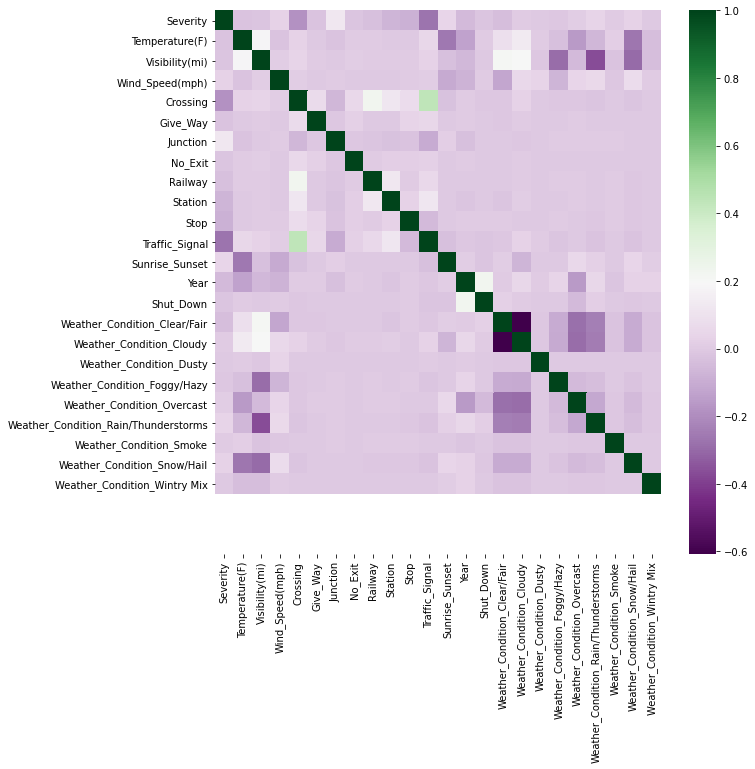

In [57]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(model_data.corr(), cmap="PRGn")
ax.set_ylim(27.0, 0);

#### Takeaways:
Not any strong standouts or unexpected correlations here.  Will need to be careful about visibility and weather conditions -- will likely just want one other.

Now look at distributions for certain values, starting with our target variable >

In [58]:
model_data.Severity.value_counts()

2    1366839
3     684975
4       6293
1        885
Name: Severity, dtype: int64

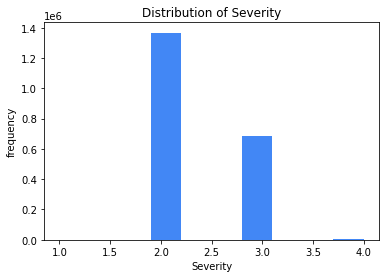

In [59]:
plt.hist(model_data["Severity"], color='#4287f5')
plt.title('Distribution of Severity')
plt.xlabel('Severity')
plt.ylabel('frequency');

This distribution is heavily weighted with '2' and '3' class severity.  '1' appears less than 1,000 times and '4' is 0.3% of total data.  This is extremely low compared to the '2' and '3' categories and worried about how trying to address imbalance will affect the model.

After consideration of options, determined that severity 1 & 2 will be combined to be 'low severity' and then 3 & 4 will be combined to be 'high severity' making our model using this set a binary classification model. 

So with that understanding, we'll change the values of severity:
- 1 & 2 Severity = 0
- 3 & 4 Severity = 1

In [60]:
# change severity 1 & 2 to equal 0 and severity 3 & 4 to equal 1

model_data['Severity'] = model_data['Severity'].map({1: 0, 
                                                     2: 0, 
                                                     3: 1,
                                                     4: 1
                                                    })

In [61]:
# verify looks as expected in dataset now (only 0s and 1s for Severity)

model_data.Severity.value_counts()

0    1367724
1     691268
Name: Severity, dtype: int64

Note the we still have imbalance that will need to be addressed for modeling.

For now, let's look at distributions of other sets of data >

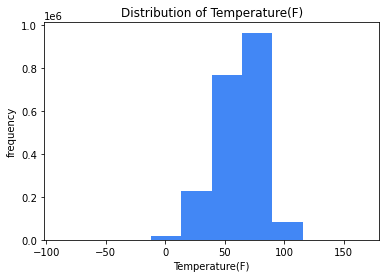

In [62]:
plt.hist(model_data["Temperature(F)"], color='#4287f5')
plt.title('Distribution of Temperature(F)')
plt.xlabel('Temperature(F)')
plt.ylabel('frequency');

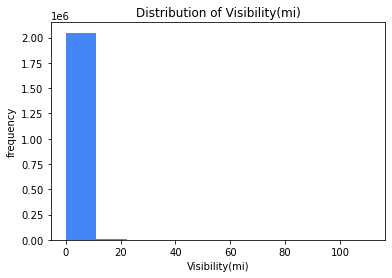

In [63]:
plt.hist(model_data["Visibility(mi)"], color='#4287f5')
plt.title('Distribution of Visibility(mi)')
plt.xlabel('Visibility(mi)')
plt.ylabel('frequency');

In [83]:
model_data['Visibility(mi)'].value_counts()

10.0     1656149
7.0        59864
9.0        53995
8.0        42463
5.0        39233
          ...   
4.5            1
36.0           1
105.0          1
101.0          1
6.2            1
Name: Visibility(mi), Length: 70, dtype: int64

There are clearly some outliers that are likely inaccurate reports.  A clear-sky day is usually said to have about 10 mile visbility, so some of these over 100 mile visibility reports are highly unlikely and not something the natural human eye could have.  Let's start with removing those >

In [64]:
model_data = model_data[model_data['Visibility(mi)'] <= 10]

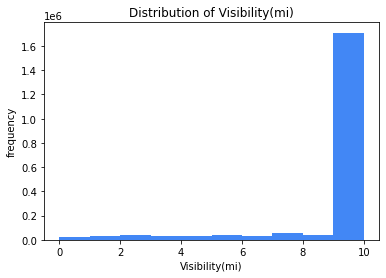

In [65]:
# now look again at the distribution

plt.hist(model_data["Visibility(mi)"], color='#4287f5')
plt.title('Distribution of Visibility(mi)')
plt.xlabel('Visibility(mi)')
plt.ylabel('frequency');

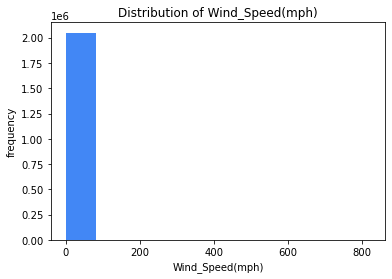

In [66]:
plt.hist(model_data["Wind_Speed(mph)"], color='#4287f5')
plt.title('Distribution of Wind_Speed(mph)')
plt.xlabel('Wind_Speed(mph)')
plt.ylabel('frequency');

In [67]:
model_data['Wind_Speed(mph)'].value_counts()

4.6      165848
5.8      163631
3.5      155112
6.9      152052
8.1      135956
          ...  
328.0         1
142.7         1
124.3         1
52.0          1
110.5         1
Name: Wind_Speed(mph), Length: 131, dtype: int64

Again we have some questionable outliers.  74-95 mph is considered very dangerous winds and 157 or higher is considered extremely dangerous -- having something over 800 is unheard of so it's doubtful that is correct.  Regardless, this model is focused on more 'common' environmental factors so it's not critical to too outliers in, as a car accident occuring during extremely high wind speeds isn't that challenging to predict.  Let's just remove the ones we can safely assume are incorrectly stated >

In [68]:
model_data = model_data[model_data['Wind_Speed(mph)'] <= 170]

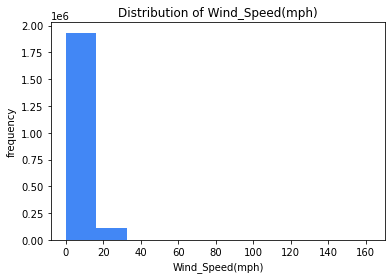

In [69]:
plt.hist(model_data["Wind_Speed(mph)"], color='#4287f5')
plt.title('Distribution of Wind_Speed(mph)')
plt.xlabel('Wind_Speed(mph)')
plt.ylabel('frequency');

Clearly the majority of wind speeds are below 20, but we'll keep the outliers that go up to 170 to account for when wind speeds are at dangerous speeds.

Now that we know the data better and have all values prepared for modeling, let's pickle the dataset to then be used in modeling in the `car_accidents_model.ipynb` notebook >

In [70]:
# save dataset as pickle

with open('pickle/model_data2.pickle', 'wb') as to_write:
    pickle.dump(model_data, to_write)